# Circle square Classification

- Author: Pawell Steven Torres Gutierrez

## Preamble

### Packages

For start this notebook here we have a summarization of the tools used around the notebook and that are imported in the next code piece:

- `matplotlib.pyplot` for the realization of graphs.
- `pandas` for data manipulation.
- `cv2` for image manipulation and filters.
- `numpy` for some efficient operations.
- `sklearn` for data scalation and for use the classification models.


In [1]:
from itertools import product
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from cv2 import (COLOR_BGR2GRAY, CV_8UC3, INTER_AREA, cvtColor, filter2D,
                 getGaborKernel, imread, resize)
from matplotlib import colors
from numpy import mean, pi
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVC

%matplotlib inline

### Dataset creation

For the creation of the dataset we used the `DBturbity.zip` data, then we used bash commands for randomize the name of every image in the `SecchiDisk_dev` and `Square_dev` folders, after that we copy the data also using bash commands in `used_data/circles` and `used_data/squares` at the end we have a total of 672 images, 336 circles and 336 squares.

## Dataset reading and manipulation

### Reading

To start we **must ask again for repectively change the path of the data when this code get reproduced**, the circles and squares are not directly read but we create a `DataFrame` with the `path` to the respective data we decide to do that in consideration of the huge memory quantity that would be lost if all the archives are loaded into a python variable, after get the `path` we make them into a `list` of `tuple` with the `path` in it and also a `0` or `1` as the classifications where `0` means circle and `1` means square, and finally we turn the path in a `DataFrame` with columns `'path'` and `'class'`.

In [2]:
# Please change to the respective path when reproducing
circles_path = '/Users/pawel/circle_square_classification/used_data/circles'
squares_path = '/Users/pawel/circle_square_classification/used_data/squares'

# Get the paths from both gorups circles and squares
data_circles = [circles_path + '/' + image.name
                for image in Path(circles_path).glob('*.png')]
data_squares = [squares_path + '/' + image.name
                for image in Path(squares_path).glob('*.png')]

# Zip the paths with the classes as 0 and 1
data_circles = list(zip(data_circles,
                        [0] * len(data_circles)))
data_squares = list(zip(data_squares,
                        [1] * len(data_squares)))

# Turn the tuples into a DataFrame
data = pd.DataFrame(data_circles + data_squares,
                    columns=['path', 'class'])

data.head()

,path,class
0,/Users/pawel/circle_square_classification/used...,0
1,/Users/pawel/circle_square_classification/used...,0
2,/Users/pawel/circle_square_classification/used...,0
3,/Users/pawel/circle_square_classification/used...,0
4,/Users/pawel/circle_square_classification/used...,0


### Gabor processing



#### Gabor processing class definition

We decide to define a class for handle the processing in favor of his eay reutilization later in the code and also in favor of a persistant `list` of `kernel` for the image filtering, the class when instantiated execute `__init__` where having the side `size` of the `kernel` and the `2 * pi` rotation divisions `r` use a vector product `product` of the pre-adjusted kernel arguments that where adjusted through visual experimentation and numerical evaluation `sigmas, thetas, limbdas, gammas, phi` that create the `list` of `tuple` called `kernel_args`, after that it turns every tuple in a `kernel` that introduce in the list `self.kernels`,

For other side the function `process` take a image path `img` and create a `list` of `float` that summarize the responsiveness of the image `img` to a given `kernel` in `self.kernels`, also as you can see there is a extra argument `for_plot` that control the return of the function so when it is `True` it returns a `list` of images to be ploted for demostration; the process itself is done by first resizing the image to `1/16` of is original size using `resize()`, then it execute a color space coonversion `cvtColor()` for make the image able to be fully filtered by the kernels in `self.kernels`, the image then is filtered in `filter2D()` finally the image is added to a `list` or is calculated the `mean` of his color values ans the added to a `list`
and that is the retunr of our function.

In [3]:
class GaborProcessingMachine():
    def __init__(self, r: int, size: int) -> None:
        self.kernels = []
        thetas = [rotation/r * pi for rotation in range(r)]
        sigmas = (10,)
        limbdas = (3, 6, 8)
        gammas =(0.1,)
        phi = (0.8,)
        kernel_args = product(sigmas, thetas, limbdas,
                              gammas, phi)
        for args in kernel_args:
            gabor = getGaborKernel((size, size), *args)
            self.kernels.append(gabor)

    def process(self, img: str,
                for_plot: bool=False) -> List[float]:
        if for_plot:
            images = []
        else:
            img_data = []
        img = imread(img)
        width = int(img.shape[1] * 0.25)
        height = int(img.shape[0] * 0.25)
        dim = (width, height)
        img = resize(img, dim, interpolation=INTER_AREA)
        img = cvtColor(img, COLOR_BGR2GRAY)
        for kernel in self.kernels:
            fimg = filter2D(img, CV_8UC3, kernel)
            try:
                images.append(fimg)
            except UnboundLocalError:
                row_means = [mean(row)for row in fimg]
                img_data.append(mean(row_means))
        try:
            return images
        except UnboundLocalError:
            return img_data

#### Gabor processing examples

The next code generate a group of images filtered by the kernels for visual reference of the process that the class `GaborProcessingMachine` execute.

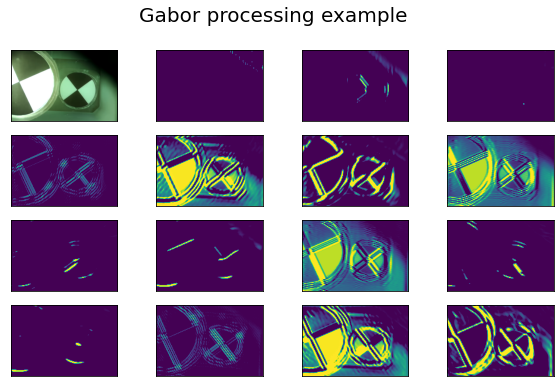

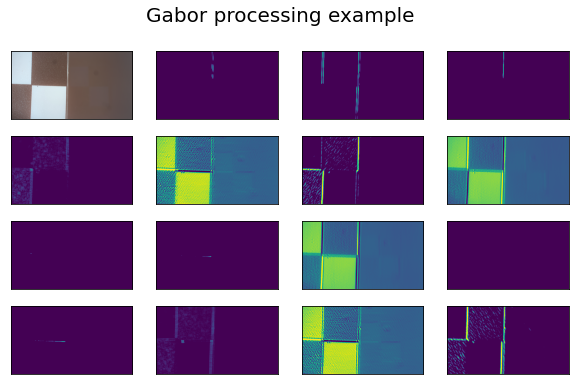

In [4]:
def gabor_example(image_index: int) -> None:
    gabor = GaborProcessingMachine(5, 10)
    example_image = data.iloc[image_index]['path']
    process_example = gabor.process(example_image, True)
    process_example = ([imread(example_image)]
                    + process_example)

    f, axarr = plt.subplots(4, 4, figsize=(10, 6))
    c = 0
    for i, j in product([*range(4)], [*range(4)]):
        axarr[i, j].imshow(process_example[c])
        axarr[i, j].set_xticks([])
        axarr[i, j].set_yticks([])
        c += 1
    f.suptitle('Gabor processing example', size=20)
    f.set_facecolor('#ffffff')
    plt.show()

gabor_example(0)
gabor_example(336)

#### Gabor processing data generation

This part of the process is almos self explanatory, creating the `list` of `list` of floats, then creating a `list` of `tuple` that contain a specific data `x_i`, after that creating a `dict` with the names of the data `x_i` and the data itself and making it into a `DataFrame` called `gabor_data`; finally joining it into our final `DataFrame` called `processed_data`.

In [5]:
gabor = GaborProcessingMachine(9, 10)

gabor_data = []
for image in data['path']:
    gabor_data.append(gabor.process(image))

gabor_data = zip(*gabor_data)
gabor_data = {'x_' + str(i + 1): data for i, data in enumerate(gabor_data)}
gabor_data = pd.DataFrame(gabor_data)

processed_data = data.join(gabor_data)
processed_data.head()

,path,class,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,...,x_18,x_19,x_20,x_21,x_22,x_23,x_24,x_25,x_26,x_27
0,/Users/pawel/circle_square_classification/used...,0,0.002685,3.259213,0.019028,142.876111,1.905370,1.232269,70.096759,168.482083,...,1.921667,35.268657,14.506944,16.208935,77.029074,167.592731,119.497870,139.554815,4.648380,2.399907
1,/Users/pawel/circle_square_classification/used...,0,0.025093,2.269907,0.332917,143.782593,1.324537,1.998056,71.381250,199.958287,...,1.454444,31.219676,12.141667,13.274769,70.615694,197.500926,106.603102,142.312824,6.955417,2.986852
2,/Users/pawel/circle_square_classification/used...,0,0.165903,1.758781,0.042832,124.777654,1.219468,0.129236,59.686752,177.340131,...,0.314846,25.833634,3.765702,4.068117,61.415309,177.812076,93.408125,124.129599,2.150031,0.888426
3,/Users/pawel/circle_square_classification/used...,0,0.000000,0.504028,0.071852,151.184352,0.168657,0.239907,71.069815,212.376157,...,0.371759,29.062731,7.396111,6.931435,70.689630,209.272824,109.243333,149.826111,3.053148,0.642500
4,/Users/pawel/circle_square_classification/used...,0,0.000000,0.004498,0.000000,184.632616,0.004306,0.000000,83.913812,252.681721,...,0.000000,33.164784,0.404799,0.186890,84.589506,252.069236,124.631350,183.961312,0.000949,0.000000


## Data visualization

### Scatter matrix

We plot the next `scatter_matrix` as a hope giver and also as a tool for the adjust of the parameters in our Gabor kernels, the matrix don't count with labels neither ticks because we consider that his information can be extracted visually and that ticks and labels are superfluous in this specific case.

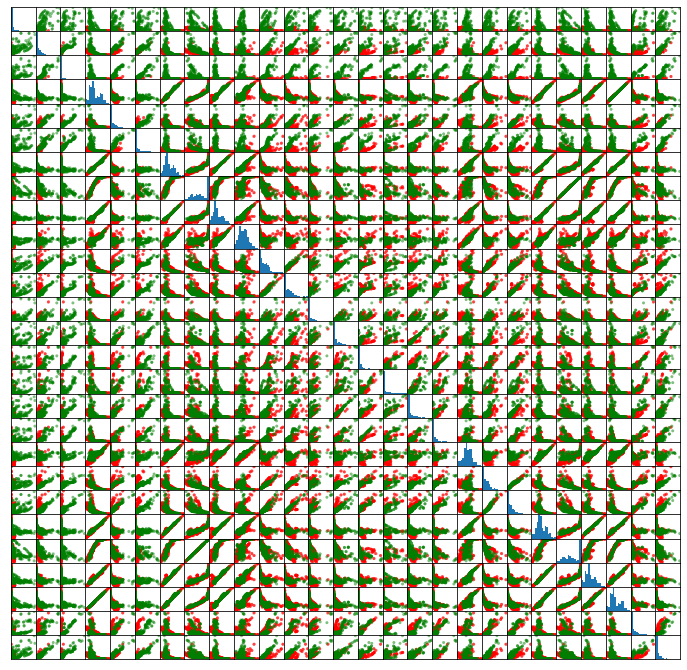

In [6]:
cmap = colors.ListedColormap(['red', 'green'])
x_data = processed_data.drop(['path','class'], axis=1)
classification_data = processed_data['class']
scatter = pd.plotting.scatter_matrix(x_data, c = classification_data,
                                     hist_kwds={'bins':15},
                                     figsize=(12,12), cmap = cmap)
for i, j in product([*range(scatter.shape[0])],
                    [*range(scatter.shape[1])]):
        scatter[i, j].set_xticks([])
        scatter[i, j].set_yticks([])
        scatter[i, j].get_xaxis().set_visible(False)
        scatter[i, j].get_yaxis().set_visible(False)

### Boxplot by class

We plot this `boxplot` for have a fast resume of the statistical characteristics in comparison of the data by its `class`, the ticks also had been deactivated for this plot sice we really dont care about the puntual values of the data but about the characteristics we can determine by using the boxplot look, the important characteristic we managed to extract from this data is how much the **outliners** are by every `class` in certain `x_i`, this observation is what influence our decision for use `RobustScaler()` that is recommended in cases with a big number of **outliners** over others scaling methods.

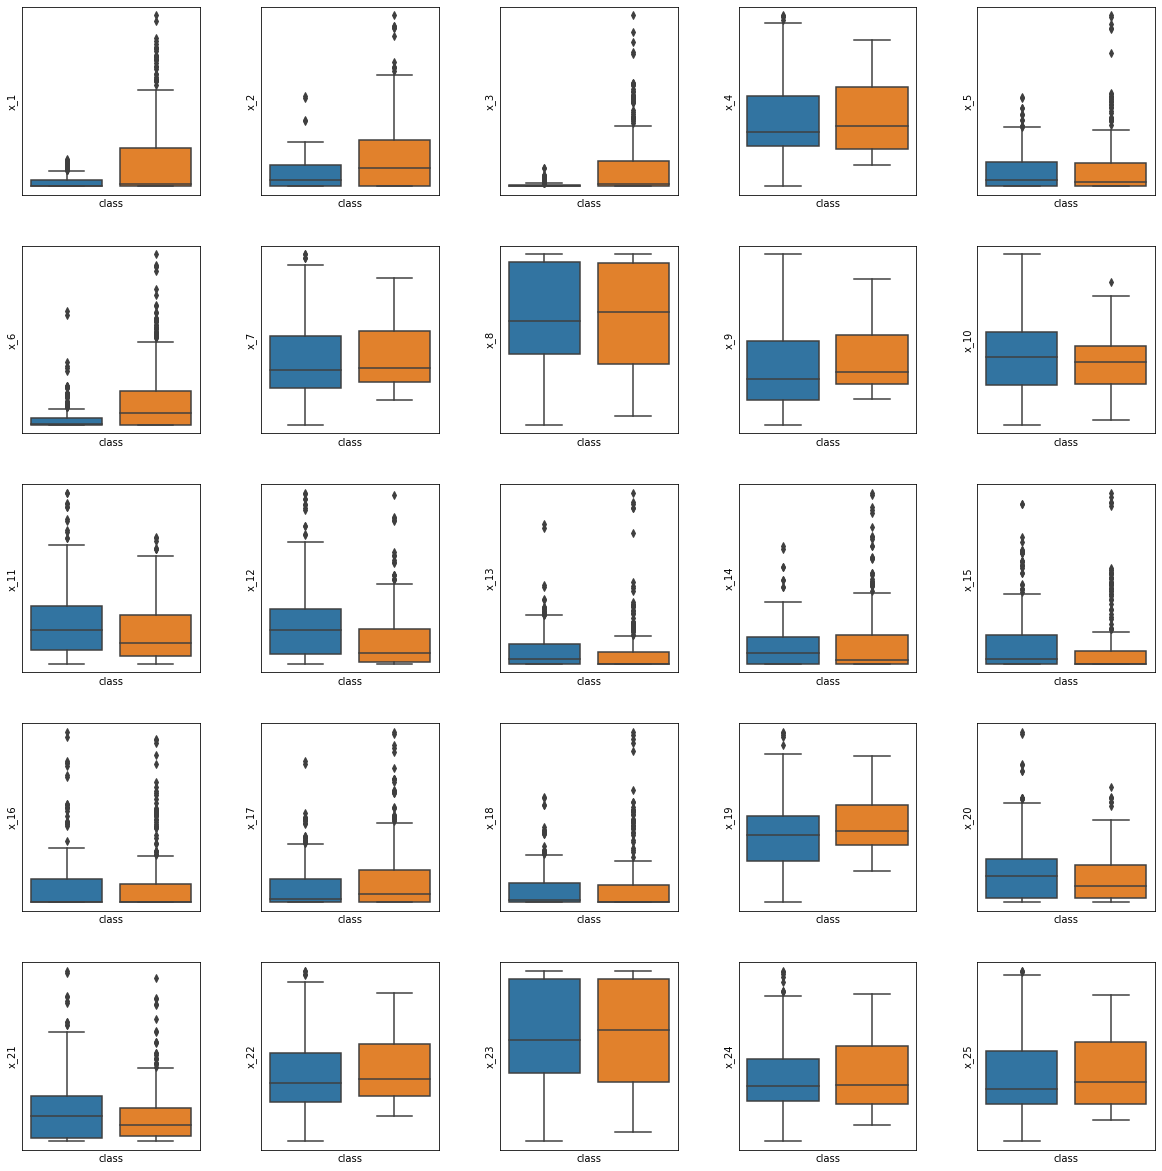

In [7]:
fig, axarr = plt.subplots(5 , 5, figsize=(17,17))
c = 0
fig.tight_layout(pad=3)
for i, j in product([*range(axarr.shape[0])],
                    [*range(axarr.shape[1])]):
    try:
        sns.boxplot(ax=axarr[i, j], x=processed_data[processed_data.columns[1]],
                    y=processed_data[processed_data.columns[2 + c]])
        axarr[i, j].set_xticks([])
        axarr[i, j].set_yticks([])
        c += 1
    except IndexError:
        axarr[i, j].set_visible(False)

plt.show()

## Training

### Training, validation and testing sets contruction.

This section is particularly short since really we only replicate the way of choosing from the reference code given to us, it keeps the reproducibility of the notebook.

In [8]:
(x_data_train,
 x_data_test,
 classification_data_train,
 classification_data_test) = train_test_split(x_data, classification_data,
                                               random_state=0)
(x_data_train,
 x_data_validation,
 classification_data_train,
 classification_data_validation) = train_test_split(x_data_train,
                                                    classification_data_train,
                                                    random_state=1)

print(f'The training dataset have {x_data_train.shape[0]} samples.')
print(f'The validation dataset have {x_data_validation.shape[0]} samples.')
print(f'The test dataset have {x_data_test.shape[0]} samples.')

The training dataset have 378 samples.
The validation dataset have 126 samples.
The test dataset have 168 samples.


### Data scaling

As we explined before the `boxplot` influenced directly in our choosing of the `RobustScaler()` over others scaling methods, after testing over the final results changing the scaler we still thinking that the `RobustScaler()` is the best option.

In [9]:
scaler = RobustScaler()
x_data_train = scaler.fit_transform(x_data_train)
x_data_test = scaler.transform(x_data_test)
x_data_validation = scaler.transform(x_data_validation)
models = []

### Models training and validation

With full honesty we can say that outside of the way of election for the final model our apportation to this code is close to `0` as we dont feel to be expert over how optimize any longer the models and we limited to apply those, but promise to learn anout them.

 :3

#### Logistic regression

In [10]:
logreg = LogisticRegression()
logreg.fit(x_data_train, classification_data_train)

results = logreg.score(x_data_validation,  classification_data_validation)
models.append(('Logistic regression', (results, logreg)))

#### Weighted nearest neighbour classifier

In [11]:
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(x_data_train, classification_data_train)

knn2 = KNeighborsClassifier(n_neighbors=2)
knn2.fit(x_data_train, classification_data_train)

knn3 = KNeighborsClassifier(n_neighbors=3)
knn3.fit(x_data_train, classification_data_train)

results = knn1.score(x_data_validation,  classification_data_validation)
models.append(('K_NN_1 classifier', (results, knn1)))

results = knn2.score(x_data_validation,  classification_data_validation)
models.append(('K_NN_2 classifier', (results, knn2)))

results = knn3.score(x_data_validation,  classification_data_validation)
models.append(('K_NN_3 classifier', (results, knn3)))

#### Linear discriminant analysis

In [12]:
lda = LinearDiscriminantAnalysis()
lda.fit(x_data_train, classification_data_train)

results = lda.score(x_data_validation,  classification_data_validation)
models.append(('LDA classifier', (results, lda)))

#### Gaussian naive Bayes

In [13]:
gnb = GaussianNB()
gnb.fit(x_data_train, classification_data_train)

results = gnb.score(x_data_validation,  classification_data_validation)
models.append(('GNB classifier', (results, gnb)))

#### Support vector machine

In [14]:
svm = SVC()
svm.fit(x_data_train, classification_data_train)

results = svm.score(x_data_validation,  classification_data_validation)
models.append(('SVM classifier', (results, svm)))

## Test

At this point we simply print the results of accuracy of all the models, order the models by its accuracy and choose the best of thems, in the current case that had been optimized for accuracy the best results are for the Weighted nearest neighbour classifier `knn` with 97% accuracy, but by experimentation we had find that this results change in a lot of cases, most of the casses being the best options the Linear discriminant analysis `lda` and the Weighted nearest neighbour classifier `knn`, also by reducing dimensionality trading less accuracy for fastest processing we had find that Logistic regression `logreg` make a excelent work in those cases.

In [15]:
models = sorted(models, key = lambda x:x[1][0])[::-1]
for model in models:
    print(f'Accuracy of {model[0]} in validation set is: {model[1][0]}')

print('')

model = models[0]
results = model[1][1].score(x_data_test, classification_data_test)
print(f'Accuracy of {model[0]} in test set is: {results}')

Accuracy of K_NN_2 classifier in validation set is: 1.0
Accuracy of K_NN_1 classifier in validation set is: 1.0
Accuracy of Logistic regression in validation set is: 1.0
Accuracy of LDA classifier in validation set is: 0.9920634920634921
Accuracy of K_NN_3 classifier in validation set is: 0.9920634920634921
Accuracy of SVM classifier in validation set is: 0.9047619047619048
Accuracy of GNB classifier in validation set is: 0.7936507936507936

Accuracy of K_NN_2 classifier in test set is: 0.9761904761904762


## Final test

Simply add the paths similar to the paths at the start of the archive to the test folders

In [ ]:
circles_path_test = ''
squares_path_test = ''

data_circles_test = [circles_path_test + '/' + image.name
                for image in Path(circles_path_test).glob('*.png')]
data_squares_test = [squares_path_test + '/' + image.name
                for image in Path(squares_path_test).glob('*.png')]

# Zip the paths with the classes as 0 and 1
data_circles_test = list(zip(data_circles_test,
                        [0] * len(data_circles_test)))
data_squares_test = list(zip(data_squares_test,
                        [1] * len(data_squares_test)))

# Turn the tuples into a DataFrame
data_test = pd.DataFrame(data_circles_test + data_squares_test,
                    columns=['path', 'class'])

gabor = GaborProcessingMachine(9, 10)

gabor_data_test = []
for image in data_test['path']:
    gabor_data_test.append(gabor.process(image))

gabor_data_test = zip(*gabor_data_test)
gabor_data_test = {'x_' + str(i + 1): data for i, data in enumerate(gabor_data_test)}
gabor_data_test = pd.DataFrame(gabor_data_test)

processed_data_test = data_test.join(gabor_data_test)

x_data_ftest = processed_data_test.drop(['path','class'], axis=1)
classification_data_ftest = processed_data_test['class']

print(f'The final test dataset have {x_data_ftest.shape[0]} samples')

scaler = RobustScaler()
x_data_ftest = scaler.fit_transform(x_data_ftest)

results = knn2.score(x_data_ftest, classification_data_ftest)
print(f'The accuracy of KNN in final test set is: {results:.2f}')


## Bibliography

- [Tutorial 74 - What are Gabor filters and how to use them to generate features for machine learning?](https://www.youtube.com/watch?v=yn1NUwaxhZg&ab_channel=Apeer_micro)
- [Tutorial 75 - Extracting features for machine learning using Gabor filter banks](https://www.youtube.com/watch?v=ywyomOyXpxg&ab_channel=Apeer_micro)
- [Through The Eyes of Gabor Filter](https://medium.com/@anuj_shah/through-the-eyes-of-gabor-filter-17d1fdb3ac97)

## Github

- [YamiYume/circle_square_classification](https://github.com/YamiYume/circle_square_classification)